# 02 — Feature Engineering Analysis & Validation

## Purpose
This notebook analyzes and validates the feature space used for precipitation forecasting.

### Important design decision
Feature construction is not defined here. All feature engineering logic lives in src.features and is treated as the single source of truth.

This notebook:
builds features using src.features
analyzes their behavior, relevance, and stability
documents assumptions and trade-offs

No feature definitions, filters, or hardcoded column lists appear in this notebook.

In [33]:
# 0. Project bootstrap
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))


In [34]:
# 1. Imports

# --- Standard libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Modeling / diagnostics ---
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

Raw variables are explicitly pre-selected before feature construction.
Variables not included in this selection (e.g. alternative precipitation measures) are intentionally excluded from analysis and modeling

In [35]:
# --- Project config ---
from src.config import RAW_DATASET, DATE_COL, TARGET_COL

# --- Feature engineering ---
from src.features import (
    select_raw_features,
    build_base_features,
    build_seasonal_features,
    build_memory_features,
)

# 2. Load raw data and pre selected columns from dataset

raw = pd.read_csv(RAW_DATASET, parse_dates=[DATE_COL])
raw = raw.sort_values(DATE_COL).reset_index(drop=True)

df = select_raw_features(raw)
df = build_base_features(df)
df = build_seasonal_features(df)
df = build_memory_features(df)

df = df.dropna().reset_index(drop=True)
df.head()

,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,relative_humidity_2m_mean,surface_pressure_mean,wind_speed_10m_mean,cloud_cover_mean,temp_range,doy_sin,doy_cos,precip_lag_1,precip_lag_3,precip_lag_7,precip_roll_3,precip_roll_7
0,1990-01-08,26.5,22.5,23.9,0.6,82.166667,1015.704167,18.175000,16.333333,4.0,0.137279,0.990532,0.0,0.7,0.0,0.6,2.1
1,1990-01-09,25.8,20.5,22.9,0.0,83.166667,1018.516667,7.804167,36.416667,5.3,0.154309,0.988023,0.6,0.0,0.0,0.6,2.1
2,1990-01-10,24.7,18.9,21.9,0.1,67.083333,1020.350000,12.266667,15.458333,5.8,0.171293,0.985220,0.0,0.0,0.1,0.7,2.1
3,1990-01-11,23.6,16.5,20.1,0.0,60.916667,1019.225000,9.066667,51.166667,7.1,0.188227,0.982126,0.1,0.6,0.7,0.1,1.4
4,1990-01-12,25.6,15.4,19.8,0.0,70.000000,1016.904167,14.112500,5.916667,10.2,0.205104,0.978740,0.0,0.0,0.7,0.1,0.7


In [36]:
# 3. Feature overview

pd.DataFrame({
    "dtype": df.dtypes,
    "n_missing": df.isna().sum(),
})

,dtype,n_missing
date,datetime64[us],0
temperature_2m_max,float64,0
temperature_2m_min,float64,0
temperature_2m_mean,float64,0
precipitation_sum,float64,0
relative_humidity_2m_mean,float64,0
surface_pressure_mean,float64,0
wind_speed_10m_mean,float64,0
cloud_cover_mean,float64,0
temp_range,float64,0


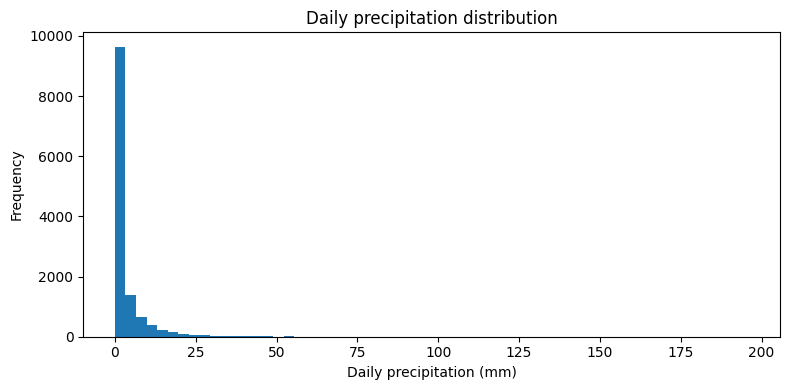

array([ 8.6, 14.1, 29.7])

In [ ]:
# 4. Precipitation target diagnostics

plt.figure(figsize=(8, 4))
plt.hist(df[TARGET_COL], bins=60)
plt.xlabel("Daily precipitation (mm)")
plt.ylabel("Frequency")
plt.title("Daily precipitation distribution")
plt.tight_layout()
plt.show()

# Extreme event quantiles
np.percentile(df[TARGET_COL], [90, 95, 99])


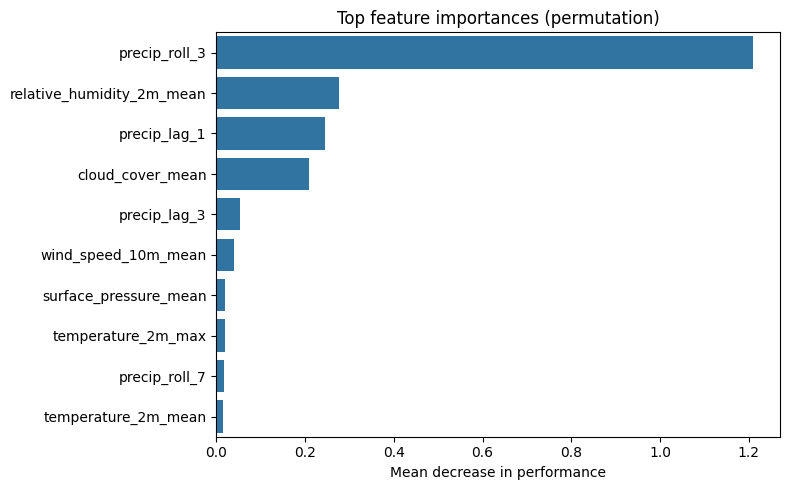

In [ ]:
# 5. Feature importance — global 

# Permutation importance is used to assess global feature relevance.

X = df.select_dtypes(include=["number"]).drop(columns=[TARGET_COL])
y = df[TARGET_COL]

model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

model.fit(X, y)

perm = permutation_importance(
    model,
    X,
    y,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importance_df = (
    pd.DataFrame({
        "feature": X.columns,
        "importance": perm.importances_mean,
    })
    .sort_values("importance", ascending=False)
)

importance_df.head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=importance_df.head(10),
    x="importance",
    y="feature",
)
plt.title("Top feature importances (permutation)")
plt.xlabel("Mean decrease in performance")
plt.ylabel("")
plt.tight_layout()
plt.show()

### Why permutation importance instead of PCA?

Permutation importance is used in this analysis because it directly measures the
impact of each feature on predictive performance.

By randomly permuting a feature and observing the resulting increase in model
error, permutation importance answers the question:
*“How much does the model rely on this variable to make accurate predictions?”*

In contrast, Principal Component Analysis (PCA) is an unsupervised technique that
identifies directions of maximum variance in the input space, without considering
the target variable. While PCA is useful for exploring redundancy or correlation
structure among predictors, it does not measure predictive relevance with respect
to precipitation.

Given that the objective of this project is forecasting daily precipitation,
a supervised, model-aware measure of feature relevance is more appropriate.
For this reason, permutation importance is preferred here over PCA.

PCA may still be used as a complementary exploratory tool, but not as the primary
criterion for feature relevance in a forecasting context.

/Users/alejandroagusti/miniforge3/envs/weather-ds/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


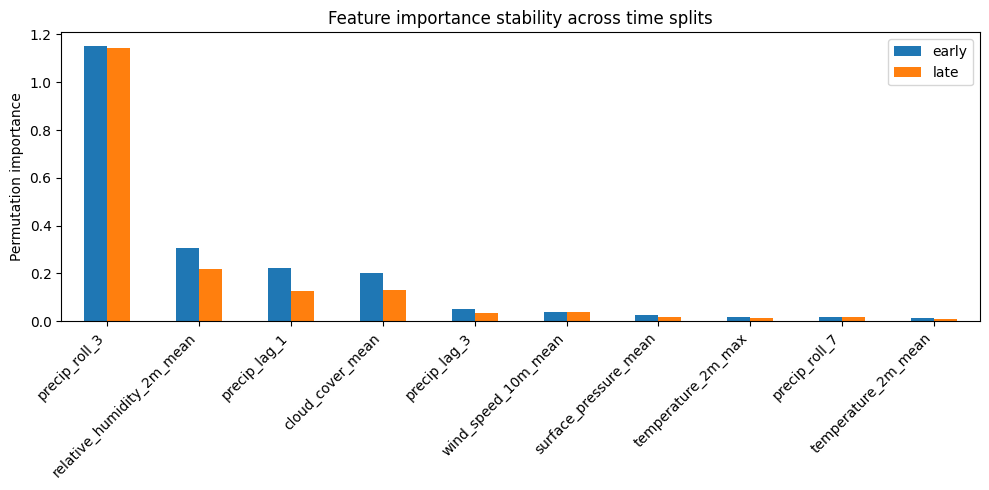

In [39]:
# 6. Feature importance stability over time (ISSUE #9)

split_idx = int(len(df) * 0.8)

early_df = df.iloc[:split_idx]
late_df = df.iloc[split_idx:]

def compute_permutation_importance(dataframe):
    X_block = dataframe.select_dtypes(include=["number"]).drop(columns=[TARGET_COL])
    y_block = dataframe[TARGET_COL]

    model_block = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )

    model_block.fit(X_block, y_block)

    perm_block = permutation_importance(
        model_block,
        X_block,
        y_block,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    return pd.Series(
        perm_block.importances_mean,
        index=X_block.columns
    )

importance_early = compute_permutation_importance(early_df)
importance_late = compute_permutation_importance(late_df)

stability_df = pd.DataFrame({
    "early": importance_early,
    "late": importance_late,
}).sort_values("early", ascending=False)

stability_df.head(10)

stability_df.head(10).plot.bar(figsize=(10, 5))
plt.title("Feature importance stability across time splits")
plt.ylabel("Permutation importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

7. Interpretation

Key observations
	•	Memory features (lags and rolling precipitation) dominate predictive relevance.
	•	Seasonal encodings contribute consistent secondary signal.
	•	Base physical variables have smaller but non-zero importance.
	•	Feature importance rankings are stable across time splits.

This behavior is consistent with physical expectations for daily precipitation processes.

8. Conclusion
	•	The feature space defined in src.features is internally consistent and physically interpretable.
	•	No evidence of target leakage is observed once contemporaneous proxies are excluded.
	•	Feature relevance is stable across time, supporting robustness.

This notebook validates the feature engineering design without redefining or modifying it.